# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. 
Particularly in this case based on VGG16

In [1]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from tensorflow.keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import np_utils

In [4]:
pip install np_utils

Note: you may need to restart the kernel to use updated packages.


In [5]:
import np_utils

## Load and Prepare DataSet

In [27]:
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 7s 0us/step


Split training dataset in train and validation sets

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

Transform target variable/labels into one hot encoded form

In [10]:
from keras.utils import to_categorical

In [12]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```scipy`` to resize images to required dimensions

In [14]:
from skimage import transform
X_train = np.array([transform.resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([transform.resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([transform.resize(x, 
                                    (48, 48)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [28]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [29]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [30]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [31]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [32]:
for layer in base_model.layers:
     layer.trainable = False

In [33]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

In [35]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [36]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [37]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [38]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/15
1328/1328 [==============================] - 93s 70ms/step - loss: 0.2350 - accuracy: 0.4673 - val_loss: 0.1898 - val_accuracy: 0.5712
Epoch 2/15
1328/1328 [==============================] - 96s 72ms/step - loss: 0.1972 - accuracy: 0.5635 - val_loss: 0.1742 - val_accuracy: 0.6198
Epoch 3/15
1328/1328 [==============================] - 94s 71ms/step - loss: 0.1849 - accuracy: 0.5988 - val_loss: 0.1690 - val_accuracy: 0.6297
Epoch 4/15
1328/1328 [==============================] - 93s 70ms/step - loss: 0.1772 - accuracy: 0.6165 - val_loss: 0.1636 - val_accuracy: 0.6434
Epoch 5/15
1328/1328 [==============================] - 94s 71ms/step - loss: 0.1706 - accuracy: 0.6369 - val_loss: 0.1601 - val_accuracy: 0.6489
Epoch 6/15
1328/1328 [==============================] - 92s 69ms/step - loss: 0.1653 - accuracy: 0.6453 - val_loss: 0.1580 - val_accuracy: 0.6556
Epoch 7/15
1328/1328 [==============================] - 94s 71ms/step - loss: 0.1608 - accuracy: 0.6568 - val_loss: 0.1571 -

## Analyze Model Performance

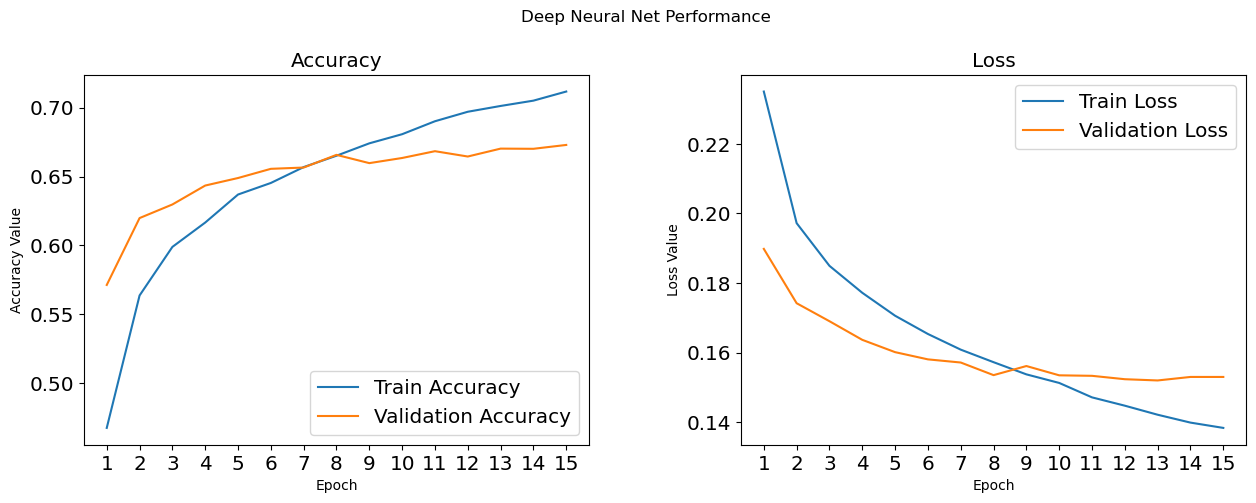

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [41]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 17s 52ms/step


In [42]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [43]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.6745
Precision: 0.6755
Recall: 0.6745
F1 Score: 0.6741


## Visualize Predictions

In [47]:
classes=['aircraft', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'hours', 'truck']

In [45]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)

AttributeError: module 'cnn_utils' has no attribute 'plot_predictions'